In [1]:
import pandas as pd
import numpy as np
import pycaret.classification as pc
import matplotlib.pyplot as plt
import mlflow

In [2]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

experiment_name = 'Projeto Kobe'
experiment = mlflow.get_experiment_by_name(experiment_name)
print(experiment)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

<Experiment: artifact_location='/Users/gabriel_01/Documents/Estudos/trab_eng_ml/ENG_ML/code/mlruns/1', creation_time=1713281813219, experiment_id='1', last_update_time=1713281813219, lifecycle_stage='active', name='Projeto Kobe', tags={}>


In [3]:
from sklearn.model_selection import train_test_split

data_cols = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']
train_perc = 0.8

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):

    df_dev = pd.read_parquet('../data/raw/dataset_kobe_dev.parquet')

    #Eliminate rows with missing values
    df_dev = df_dev.dropna(subset=data_cols)
    df_dev = df_dev[data_cols].copy()

    df_dev.to_parquet('../data/processed/data_filtered.parquet')
    print(f"Dimensão do dataset: {df_dev.shape}")

    xtrain, xtest, ytrain, ytest = train_test_split(
        df_dev[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']],
        df_dev['shot_made_flag'],
        train_size=train_perc,
        stratify=df_dev['shot_made_flag']
    )

    xtrain['shot_made_flag'] = ytrain
    xtest['shot_made_flag'] = ytest

    xtrain.to_parquet('../data/processed/base_train.parquet')
    xtest.to_parquet('../data/processed/base_test.parquet')

    mlflow.log_params({
        'perc_test': 1-train_perc,
        'colunas-selecionadas': data_cols
    })
    
    mlflow.log_metrics({
        'qtd_linhas_treino': xtrain.shape[0],
        'qtd_linhas_teste': xtest.shape[0],
    })

Dimensão do dataset: (20285, 7)


# Análise exploratória

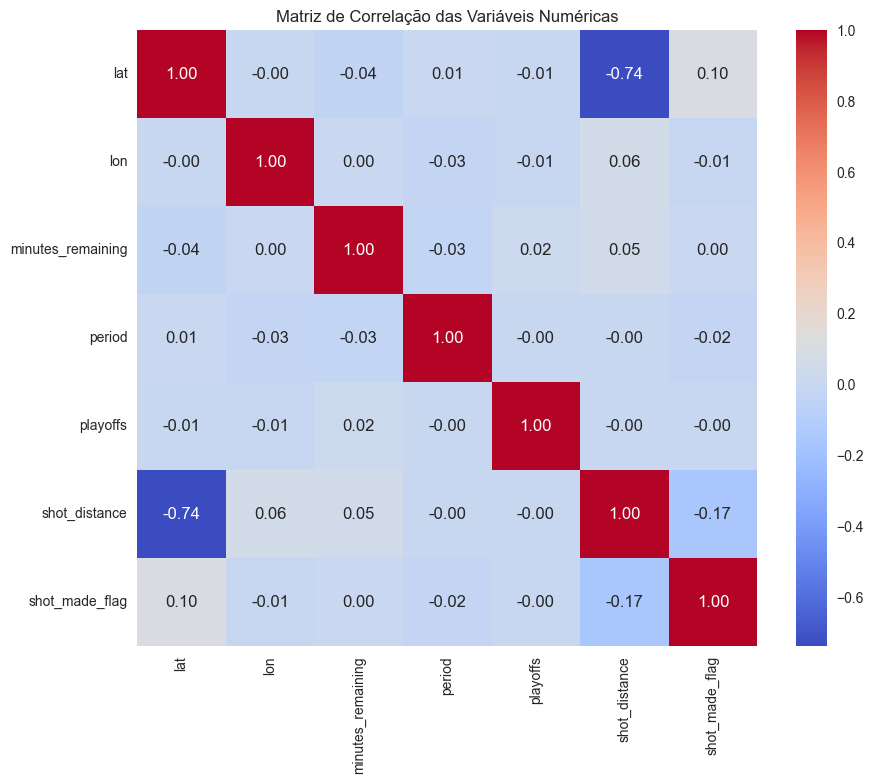

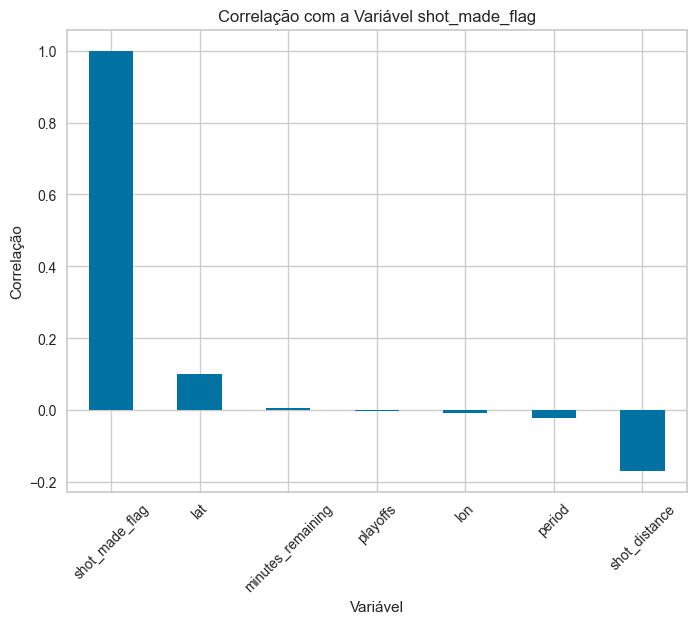

Teste qui-quadrado para period: p-valor = 0.02549641407197357
Teste qui-quadrado para playoffs: p-valor = 0.7027926000950303


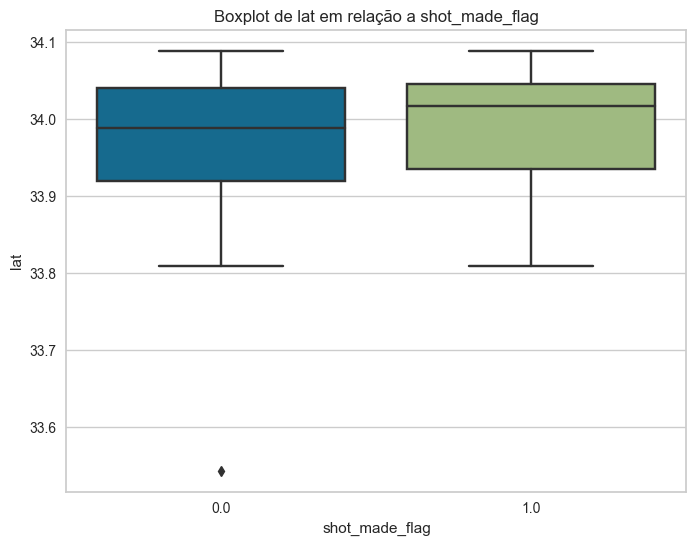

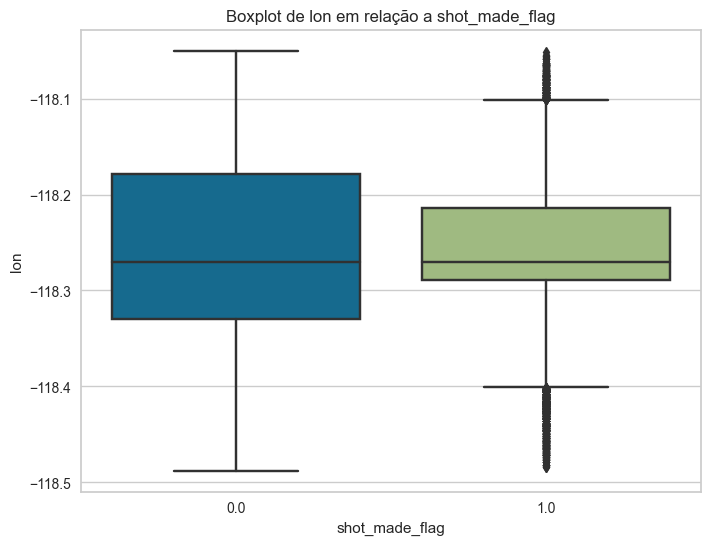

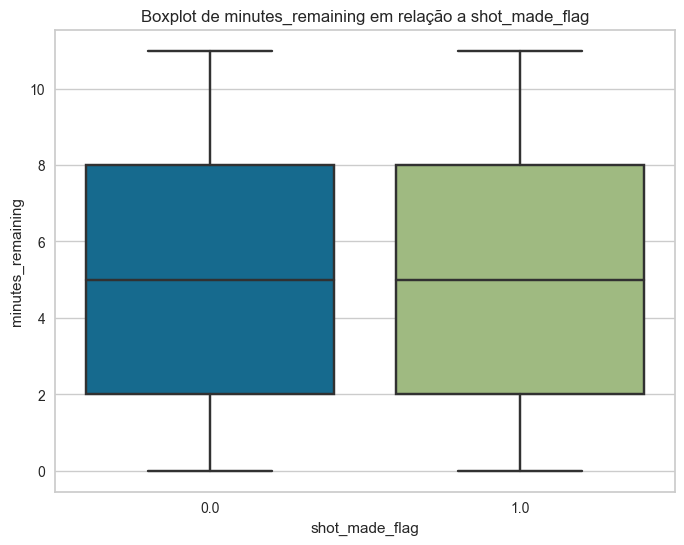

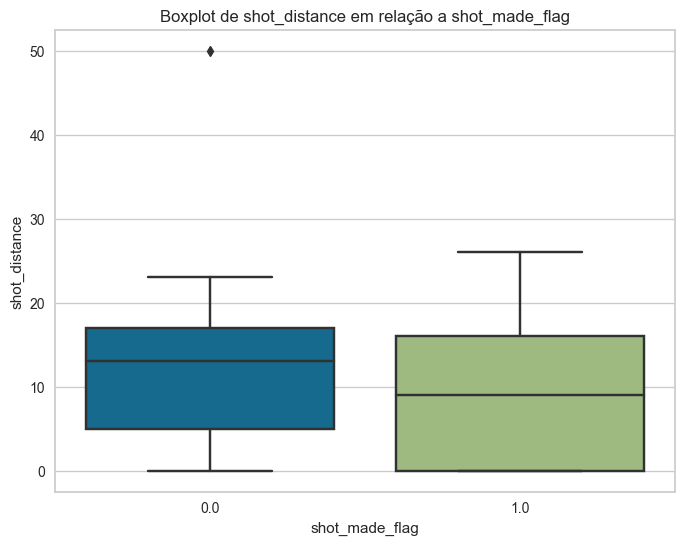

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Carregar os dados
df = pd.read_parquet('../data/processed/data_filtered.parquet')

# Calcular a correlação entre as variáveis numéricas
correlation_matrix = df.corr()

# Plotar um heatmap da matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação das Variáveis Numéricas')
plt.show()

# Calcular a correlação entre a variável categórica 'shot_made_flag' e as variáveis numéricas
corr_with_target = df.corrwith(df['shot_made_flag']).sort_values(ascending=False)

# Plotar barras mostrando a correlação com 'shot_made_flag'
plt.figure(figsize=(8, 6))
corr_with_target.plot(kind='bar')
plt.title('Correlação com a Variável shot_made_flag')
plt.ylabel('Correlação')
plt.xlabel('Variável')
plt.xticks(rotation=45)
plt.show()

# Teste qui-quadrado para variáveis categóricas
categorical_vars = ['period', 'playoffs']
for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['shot_made_flag'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Teste qui-quadrado para {var}: p-valor = {p}")

# Plotar boxplots para variáveis numéricas em relação a 'shot_made_flag'
numeric_vars = ['lat', 'lon', 'minutes_remaining', 'shot_distance']
for var in numeric_vars:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='shot_made_flag', y=var, data=df)
    plt.title(f'Boxplot de {var} em relação a shot_made_flag')
    plt.xlabel('shot_made_flag')
    plt.ylabel(var)
    plt.show()


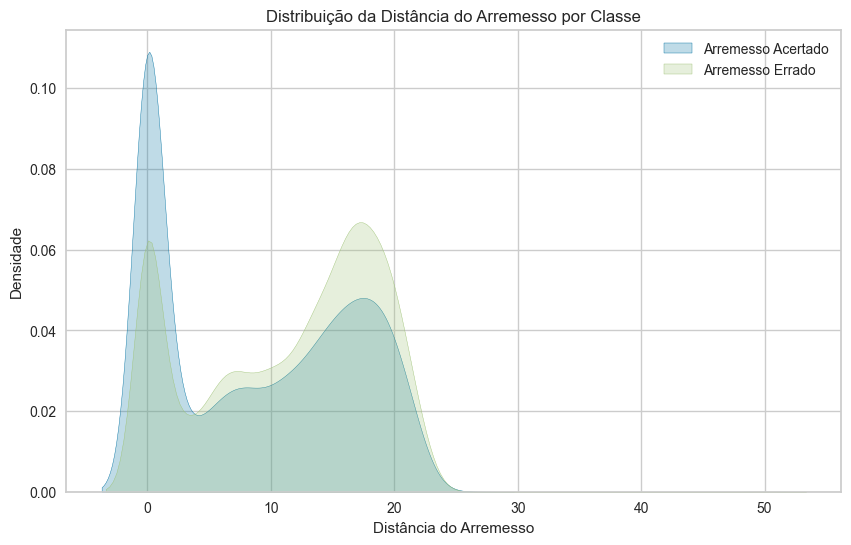

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dividir o dataframe em duas classes: acertou o arremesso (1) e errou o arremesso (0)
df_made = df[df['shot_made_flag'] == 1]
df_missed = df[df['shot_made_flag'] == 0]

# Plotar a distribuição da variável 'shot_distance' para cada classe
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_made['shot_distance'], label='Arremesso Acertado', shade=True)
sns.kdeplot(data=df_missed['shot_distance'], label='Arremesso Errado', shade=True)
plt.title('Distribuição da Distância do Arremesso por Classe')
plt.xlabel('Distância do Arremesso')
plt.ylabel('Densidade')
plt.legend()
plt.show()


In [6]:
import pandas as pd

# Calcular estatísticas resumidas para a variável 'shot_distance' para cada classe
stats_made = df[df['shot_made_flag'] == 1]['shot_distance'].describe()
stats_missed = df[df['shot_made_flag'] == 0]['shot_distance'].describe()

# Criar um dataframe com as estatísticas
stats_df = pd.DataFrame({
    'Classe': ['Arremesso Feito', 'Arremesso Não Feito'],
    'Média da Distância': [stats_made['mean'], stats_missed['mean']],
    'Desvio Padrão da Distância': [stats_made['std'], stats_missed['std']],
    'Mínimo da Distância': [stats_made['min'], stats_missed['min']],
    'Máximo da Distância': [stats_made['max'], stats_missed['max']]
})

# Mostrar o dataframe
print(stats_df)


                Classe  Média da Distância  Desvio Padrão da Distância  \
0      Arremesso Feito            8.886089                    7.744722   
1  Arremesso Não Feito           11.431239                    7.174358   

   Mínimo da Distância  Máximo da Distância  
0                  0.0                 26.0  
1                  0.0                 50.0  


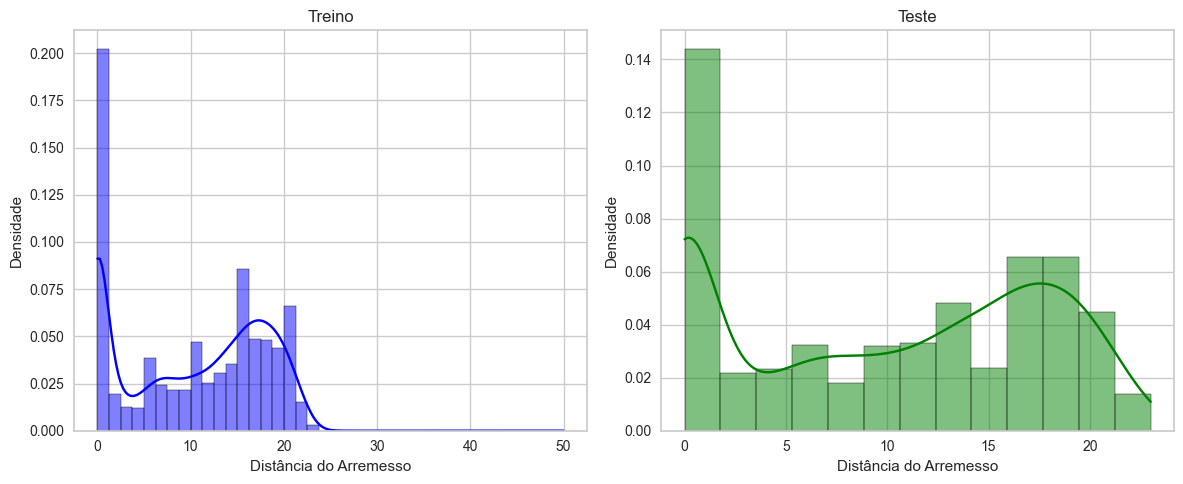

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os conjuntos de treino e teste
train_df = pd.read_parquet('../data/processed/base_train.parquet')
test_df = pd.read_parquet('../data/processed/base_test.parquet')

# Criar figura com dois subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotar a distribuição da variável 'shot_distance' para o conjunto de treino
sns.histplot(train_df['shot_distance'], kde=True, color='blue', label='Treino', stat='density', ax=axs[0])
axs[0].set_title('Treino')
axs[0].set_xlabel('Distância do Arremesso')
axs[0].set_ylabel('Densidade')

# Plotar a distribuição da variável 'shot_distance' para o conjunto de teste
sns.histplot(test_df['shot_distance'], kde=True, color='green', label='Teste', stat='density', ax=axs[1])
axs[1].set_title('Teste')
axs[1].set_xlabel('Distância do Arremesso')
axs[1].set_ylabel('Densidade')

# Ajustar o layout
plt.tight_layout()
plt.show()


# Treinamento do modelo

In [8]:
import os
from sklearn.metrics import log_loss, f1_score
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient


registered_model_name = 'projeto_kobe'
nexamples = 5
model_version = -1


with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    exp = pc.setup(
        data=xtrain,
        target='shot_made_flag',
        test_data=xtest,
        normalize=True,
        log_experiment=False
    )
    ## Treinamento DT
    list_models = exp.compare_models(['lr', 'dt'], n_select=2, sort='f1')

    yhat_test = exp.predict_model(list_models[0])

    mlflow.log_metrics({
        'dt_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
        'dt_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })

    exp.plot_model(list_models[0], plot='vc', save=True)
    os.rename('Validation Curve.png', 'dt_validation_curve.png')
    mlflow.log_artifact('dt_validation_curve.png')

    ## Treinamento LR

    yhat_test = exp.predict_model(list_models[1])

    mlflow.log_metrics({
        'lr_log_loss': log_loss(yhat_test.shot_made_flag, yhat_test.prediction_label),
        'lr_f1': f1_score(yhat_test.shot_made_flag, yhat_test.prediction_label)
    })

    exp.plot_model(list_models[1], plot='vc', save=True)
    os.rename('Validation Curve.png', 'lr_validation_curve.png')
    mlflow.log_artifact('lr_validation_curve.png')

    # Finalização melhor modelo DT

    tune_model = exp.tune_model(
        list_models[0],
        optimize='f1',
        search_library='scikit-learn',
        search_algorithm='random',
        n_iter=4,
    )

    yhat_test = exp.predict_model(tune_model, raw_score=True)

    mlflow.log_metrics({
        'final_model_log_loss': log_loss(yhat_test['shot_made_flag'], yhat_test.prediction_label),
        'final_model_f1': f1_score(yhat_test['shot_made_flag'], yhat_test.prediction_label),
    })
    yhat_test.to_parquet('../data/processed/prediction_test.parquet')
    mlflow.log_artifact('../data/processed/prediction_test.parquet')

    final_model = exp.finalize_model(tune_model)

    # Exportacao para log e registro do modelo
    exp.save_model(final_model, f'./{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = exp.load_model(f'./{registered_model_name}')
    # Assinatura do Modelo Inferida pelo MLFlow
    model_features = list(xtrain.drop('shot_made_flag', axis=1).columns)
    inf_signature = infer_signature(
        xtrain[model_features],
        model_pipe.predict_proba(xtrain.drop('shot_made_flag', axis=1))
    )
    # Exemplo de entrada para o MLmodel
    input_example = {x: xtrain[x].values[:nexamples] for x in model_features}
    # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
    mlflow.sklearn.log_model(
        sk_model=model_pipe,
        artifact_path="sklearn-model",
        registered_model_name=registered_model_name,
        signature = inf_signature,
        input_example = input_example,
        pyfunc_predict_fn = 'predict_proba'
    )
    # Criacao do cliente do servico MLFlow e atualizacao versao modelo
    client = MlflowClient()
    if model_version == -1:
        model_version = client.get_latest_versions(registered_model_name)[-1].version
    
    # Registrar o modelo como staging
    client.set_registered_model_alias(
        name= registered_model_name,
        alias = 'staging',
        version = model_version
    )

,Description,Value
0,Session id,5501
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(20285, 7)"
4,Transformed data shape,"(20285, 7)"
5,Transformed train set shape,"(16228, 7)"
6,Transformed test set shape,"(4057, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.5379,0.5191,0.5775,0.5142,0.5440,0.0788,0.0794,0.0130
lr,Logistic Regression,0.5796,0.6008,0.4888,0.5698,0.5260,0.1523,0.1539,0.2120


Processing:   0%|          | 0/14 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5366,0.5143,0.5679,0.5133,0.5392,0.0756,0.0760


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5679,0.5874,0.4817,0.5547,0.5156,0.1291,0.1302


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6001,0.6025,0.4251,0.6173,0.5034,0.1874,0.1965
1,0.6081,0.6170,0.4651,0.6186,0.5310,0.2059,0.2121
2,0.5804,0.5887,0.4052,0.5880,0.4798,0.1477,0.1549
3,0.6081,0.6223,0.4400,0.6280,0.5175,0.2044,0.2136
4,0.5687,0.5741,0.4671,0.5578,0.5084,0.1296,0.1312
5,0.5890,0.5987,0.4232,0.5985,0.4958,0.1659,0.1730
6,0.5952,0.5902,0.4323,0.6069,0.5049,0.1786,0.1859
7,0.5730,0.5812,0.5058,0.5584,0.5308,0.1408,0.1414
8,0.5771,0.5724,0.4225,0.5777,0.4881,0.1423,0.1474


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5366,0.5143,0.5679,0.5133,0.5392,0.0756,0.0760


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Registered model 'projeto_kobe' already exists. Creating a new version of this model...
Created version '7' of model 'projeto_kobe'.


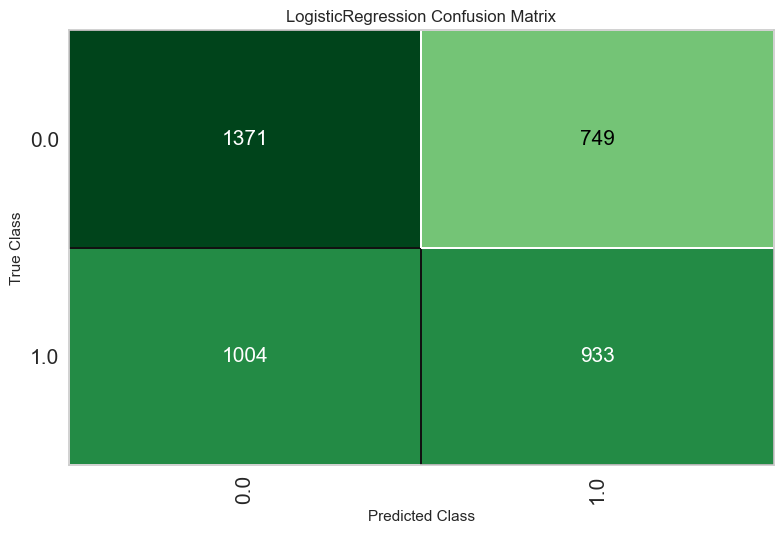

In [9]:
from pycaret.classification import plot_model

# Plotar a matriz de confusão
plot_model(list_models[1], plot='confusion_matrix')

In [21]:
yhat_dt

,lat,lon,minutes_remaining,period,playoffs,shot_distance,shot_made_flag,prediction_label,prediction_score_0,prediction_score_1
18371,33.907299,-118.427803,7,2,0,20,0.0,1,0.0,1.0
2837,34.046299,-118.395798,7,4,0,12,0.0,0,1.0,0.0
11792,34.047298,-118.083801,3,2,0,18,0.0,0,1.0,0.0
10736,33.967300,-118.141800,9,4,0,14,0.0,0,1.0,0.0
22963,33.906300,-118.240799,7,4,0,14,0.0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
27036,34.057301,-118.415802,2,3,1,14,0.0,0,1.0,0.0
10103,33.919300,-118.338799,10,3,0,14,1.0,1,0.0,1.0
9725,34.008301,-118.458801,11,3,0,19,1.0,1,0.0,1.0
26158,33.912300,-118.122803,6,1,0,19,1.0,1,0.0,1.0


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5679,0.5874,0.4817,0.5547,0.5156,0.1291,0.1302


             lat         lon  minutes_remaining  period  playoffs  \
18371  33.907299 -118.427803                  7       2         0   
2837   34.046299 -118.395798                  7       4         0   
11792  34.047298 -118.083801                  3       2         0   
10736  33.967300 -118.141800                  9       4         0   
22963  33.906300 -118.240799                  7       4         0   
...          ...         ...                ...     ...       ...   
27036  34.057301 -118.415802                  2       3         1   
10103  33.919300 -118.338799                 10       3         0   
9725   34.008301 -118.458801                 11       3         0   
26158  33.912300 -118.122803                  6       1         0   
20471  34.018299 -118.134804                  2       4         0   

       shot_distance  shot_made_flag  prediction_label  prediction_score_0  \
18371             20             0.0                 0              0.6154   
2837           

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5366,0.5143,0.5679,0.5133,0.5392,0.0756,0.0760


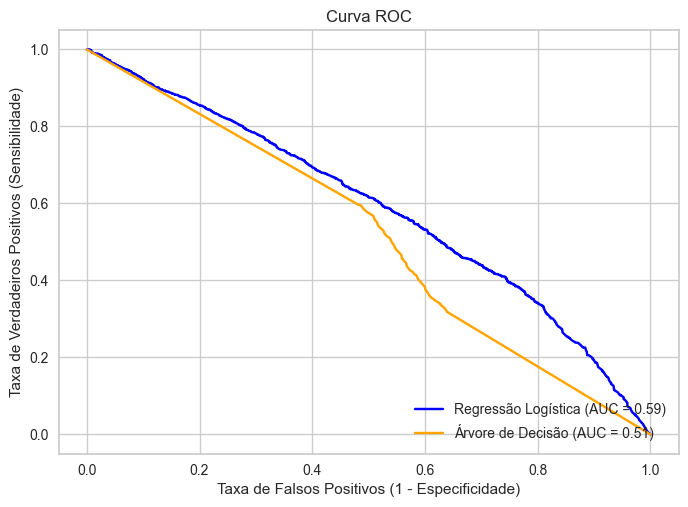

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prever probabilidades para a regressão logística e a árvore de decisão
yhat_lr = exp.predict_model(list_models[1], raw_score=True)
print(yhat_lr)
yhat_dt = exp.predict_model(list_models[0], raw_score=True)

# Calcular a curva ROC para a regressão logística e a árvore de decisão
fpr_lr, tpr_lr, _ = roc_curve(yhat_lr['shot_made_flag'], yhat_lr['prediction_score_1'])
fpr_dt, tpr_dt, _ = roc_curve(yhat_dt['shot_made_flag'], yhat_dt['prediction_score_1'])

# Calcular a área sob a curva ROC (AUC)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plotar a curva ROC para a regressão logística
plt.plot(1-fpr_lr, tpr_lr, label='Regressão Logística (AUC = {:.2f})'.format(roc_auc_lr), color='blue')

# Plotar a curva ROC para a árvore de decisão
plt.plot(1-fpr_dt, tpr_dt, label='Árvore de Decisão (AUC = {:.2f})'.format(roc_auc_dt), color='orange')

# Configurar o gráfico
plt.title('Curva ROC')
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.legend(loc='lower right')
plt.grid(True)

# Mostrar o gráfico
plt.show()


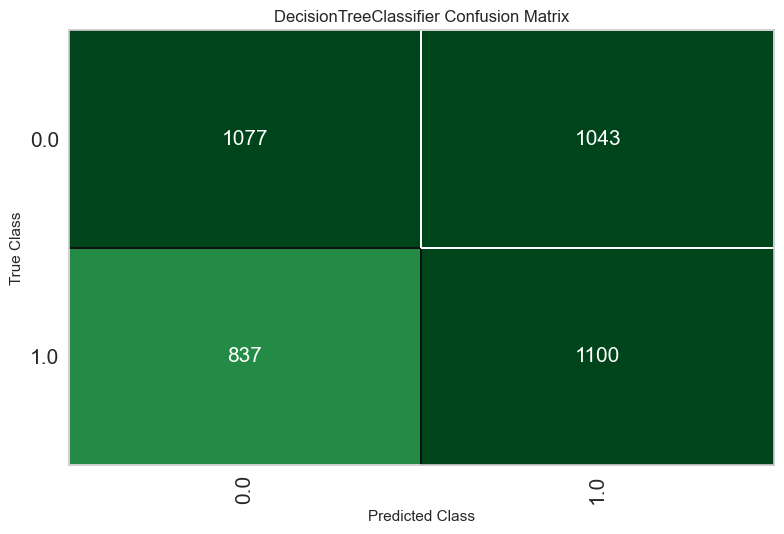

In [11]:
from pycaret.classification import plot_model

# Plotar a matriz de confusão
plot_model(list_models[0], plot='confusion_matrix')